# ERCC Transcript normalisation

In [22]:
# Import necessary libraries
import os
import sys
import pandas as pd
import numpy as np
from scipy import constants
import seaborn as sns
import matplotlib.pyplot as plt

# Add 'scripts' and its subdirectories to Python's module search path to allow importing custom modules. 
sys.path.insert(1, 'scripts')

from utils import merge_kallisto

In [23]:
# Merge kallisto counts into one dataframe
merge_kallisto('../data/ERCC92/kallisto', '../data/ERCC92')

In [24]:
# Load ERCC counts
counts_ERCC = pd.read_csv('../data/ERCC92/count.csv')
tpm_ERCC = pd.read_csv('../data/ERCC92/tpm.csv')

# Load ERCC metadata
meta_ERCC = pd.read_table('../data/ERCC92/ERCC_Controls_Analysis.txt')

# Load lab metadata
lab_info = pd.read_csv('../data/ERCC92/sampling_RNA_Spike_LibPrep.csv', sep=';', decimal=',')

# Load sample metadata
sample = pd.read_csv('../data/samples.csv', sep=';', decimal=',')

In [25]:
# Extract the squared coefficient of variance from each row
coeff_var = (np.std(counts_ERCC, axis=1) / np.mean(counts_ERCC, axis=1)) ** 2
# Extract the mean expression from each row
mean_expression = np.mean(counts_ERCC, axis=1)

In [26]:
# Combine both values in a dataframe
df = pd.DataFrame()
df['CV2'] = coeff_var
df['CV'] = np.sqrt(coeff_var)
df['mean_expression'] = mean_expression
df['log_mean_expression'] = np.log10(mean_expression + 1)

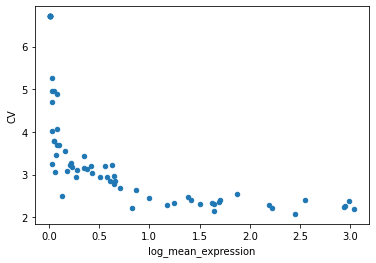

In [27]:
df.plot('log_mean_expression', 'CV', kind='scatter', alpha=1);

In [28]:
# Melt the TPM dataframe to long format
counts_ERCC = counts_ERCC.melt(id_vars=['target_id'], var_name=['sample_name'], value_name='count')
# Melt the count dataframe to long format
tpm_ERCC = tpm_ERCC.melt(id_vars=['target_id'], var_name=['sample_name'], value_name='TPM')

# Merge both
counts_ERCC = counts_ERCC.merge(tpm_ERCC, left_on=['sample_name', 'target_id'], right_on=['sample_name', 'target_id'])

# Add metadata
counts_ERCC = counts_ERCC.merge(meta_ERCC, left_on='target_id', right_on='ERCC_ID')
# Drop irrelevant columns
counts_ERCC = counts_ERCC.drop(columns=['target_id', 'Re-sort ID', 'subgroup', 'concentration_Mix_2', 'expected_fold_change ratio', 'log2_Mix_1_Mix_2'])
# Add how much spike mix was added
counts_ERCC = counts_ERCC.merge(lab_info, left_on='sample_name', right_on='sample_name')

counts_ERCC.head()

,sample_name,count,TPM,ERCC_ID,concentration_Mix_1,SW_filtered,eluate_volume_mL,rna_extraction_vol_mL,RNA_conc_ng_µl,µl_RNA_used _for_start_LP,pre_dil,ng_RNA_used_for_start_LP,µl_ERCC_spike,ERCC_dilution,sequenced_at,standards_added_by,standards_added_before
0,130_17,23,89207.1,ERCC-00002,15000.000000,50,7.5,3.0,67.514,2.96,1,200.0,4.0,0.001,Macrogen,Macrogen,library_preparation
1,130_17,0,0.0,ERCC-00003,937.500000,50,7.5,3.0,67.514,2.96,1,200.0,4.0,0.001,Macrogen,Macrogen,library_preparation
2,130_17,0,0.0,ERCC-00004,7500.000000,50,7.5,3.0,67.514,2.96,1,200.0,4.0,0.001,Macrogen,Macrogen,library_preparation
3,130_17,0,0.0,ERCC-00009,937.500000,50,7.5,3.0,67.514,2.96,1,200.0,4.0,0.001,Macrogen,Macrogen,library_preparation
4,130_17,0,0.0,ERCC-00012,0.114441,50,7.5,3.0,67.514,2.96,1,200.0,4.0,0.001,Macrogen,Macrogen,library_preparation


In [29]:
# Add transformed concentration column to reflect the amount of moles spike added which also incorporates wet lab dilution
counts_ERCC['attomoles_in_total_RNA'] = counts_ERCC['concentration_Mix_1'] * (counts_ERCC['µl_ERCC_spike'] * counts_ERCC['ERCC_dilution'])

# Calculate absolute number of molecules per sample using Avogadro's number, but first we need to converse attomoles to moles (atto = 10^-18) 
counts_ERCC['ERCC_copies'] = counts_ERCC['attomoles_in_total_RNA'] * 10**-18 *constants.Avogadro

## Lower Limit of Detection
Let's identify the smallest amount of ERCC copies that result in a detectable TPM signal

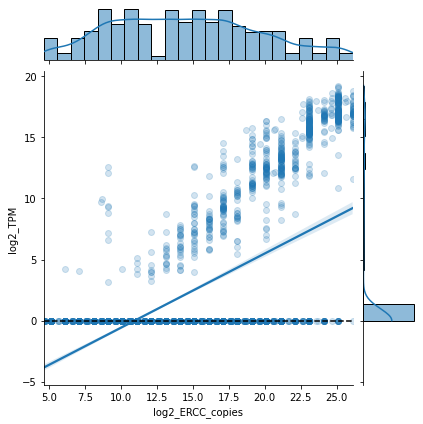

In [30]:
plotdata = counts_ERCC[['ERCC_copies', 'TPM']].copy()
# Add a pseudocount to avoid trying to get log 0
plotdata['ERCC_copies'] = np.log2(plotdata['ERCC_copies'] +1)
plotdata['TPM'] = np.log2(plotdata['TPM'] + 1)
plotdata.columns = ['log2_ERCC_copies', 'log2_TPM']

# Plot the data
plot = sns.jointplot(data=plotdata,
            x='log2_ERCC_copies',
            y='log2_TPM',
            kind='reg',
            joint_kws = {'scatter_kws':dict(alpha=0.2)}
)

# Add horizontal line at 0
plot.ax_joint.axhline(0, color='black', linestyle='--')

# Save the plot as a svg
#plot.savefig('../../figures/assembly/ERCC92_TPM_vs_copies.svg')

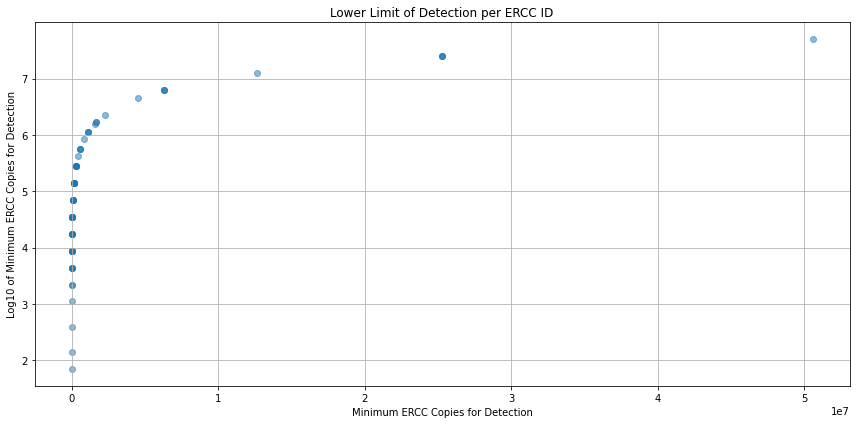

The ovarall minimum number of ERCC copies required for detection is approx. 68.91793289438992 copies.


In [31]:
# Calculate the minimum detectable TPM for each ERCC ID
detectable_tpm = counts_ERCC[counts_ERCC['TPM'] > 0]  # Filter out samples with no detected TPM
min_detectable_tpm_per_ercc = detectable_tpm.groupby('ERCC_ID')['ERCC_copies'].min().reset_index()

# Plot the relationship between ERCC copies and the minimum detectable TPM
plt.figure(figsize=(12, 6))
plt.scatter(min_detectable_tpm_per_ercc['ERCC_copies'], np.log10(min_detectable_tpm_per_ercc['ERCC_copies']), alpha=0.5)
plt.xlabel('Minimum ERCC Copies for Detection')
plt.ylabel('Log10 of Minimum ERCC Copies for Detection')
plt.title('Lower Limit of Detection per ERCC ID')
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

# Also, report the overall minimum ERCC copies detected
overall_min_ercc_copies = min_detectable_tpm_per_ercc['ERCC_copies'].min()
print('The ovarall minimum number of ERCC copies required for detection is approx. {} copies.'.format(overall_min_ercc_copies))

## ERCC Recovery per campaign
Let's see if there's differences between the two 24H cycli.

In [38]:
def plot_ercc_heatmap(df, values='count'):
    """
    Generates a heatmap displaying ERCC counts for all ERCCs across all samples.
    
    Parameters:
    - df: A pandas DataFrame containing the dataset with columns for 'sample_name', 'ERCC_ID', and 'TPM' or 'counts'.
    
    The DataFrame is expected to have a row for each ERCC-sample combination.
    """
    # Pivot the DataFrame to create a matrix of ERCC counts with samples as columns and ERCC IDs as rows
    ercc_matrix = df.pivot(index='ERCC_ID', columns='sample_name', values=values)
    
    # Plot the heatmap
    plt.figure(figsize=(20, 10))
    sns.heatmap(ercc_matrix, cmap='viridis', linewidths=0.1, linecolor='gray', cbar_kws={'label': values})
    plt.title('Heatmap of ERCC Counts Across All Samples')
    plt.xlabel('Sample Name')
    plt.ylabel('ERCC ID')
    plt.xticks(rotation=90)  # Rotate sample names for better readability
    plt.tight_layout()
    
    # Show the plot
    plt.show()

In [39]:
counts_ERCC.head()

,sample_name,count,TPM,ERCC_ID,concentration_Mix_1,SW_filtered,eluate_volume_mL,rna_extraction_vol_mL,RNA_conc_ng_µl,µl_RNA_used _for_start_LP,...,standards_added_by,standards_added_before,attomoles_in_total_RNA,ERCC_copies,date,time,station,SW filtered (L),Eluate volume (mL),RNA extraction volume (mL)
0,130_17,23,89207.1,ERCC-00002,15000.000000,50,7.5,3.0,67.514,2.96,...,Macrogen,library_preparation,60.000000,3.613284e+07,21/04/2023,02:00,130,50,7.5,3.0
1,130_17,0,0.0,ERCC-00003,937.500000,50,7.5,3.0,67.514,2.96,...,Macrogen,library_preparation,3.750000,2.258303e+06,21/04/2023,02:00,130,50,7.5,3.0
2,130_17,0,0.0,ERCC-00004,7500.000000,50,7.5,3.0,67.514,2.96,...,Macrogen,library_preparation,30.000000,1.806642e+07,21/04/2023,02:00,130,50,7.5,3.0
3,130_17,0,0.0,ERCC-00009,937.500000,50,7.5,3.0,67.514,2.96,...,Macrogen,library_preparation,3.750000,2.258303e+06,21/04/2023,02:00,130,50,7.5,3.0
4,130_17,0,0.0,ERCC-00012,0.114441,50,7.5,3.0,67.514,2.96,...,Macrogen,library_preparation,0.000458,2.756717e+02,21/04/2023,02:00,130,50,7.5,3.0


In [34]:
counts_ERCC = counts_ERCC.merge(sample, on='sample_name')

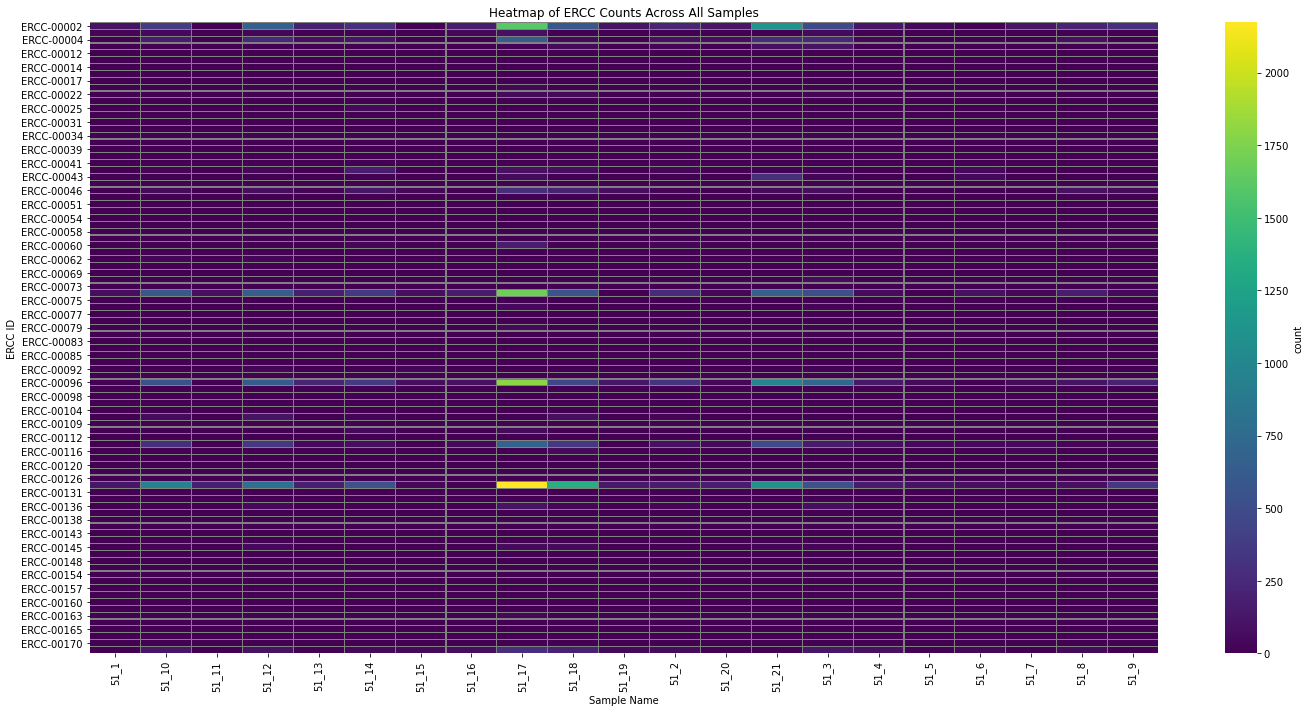

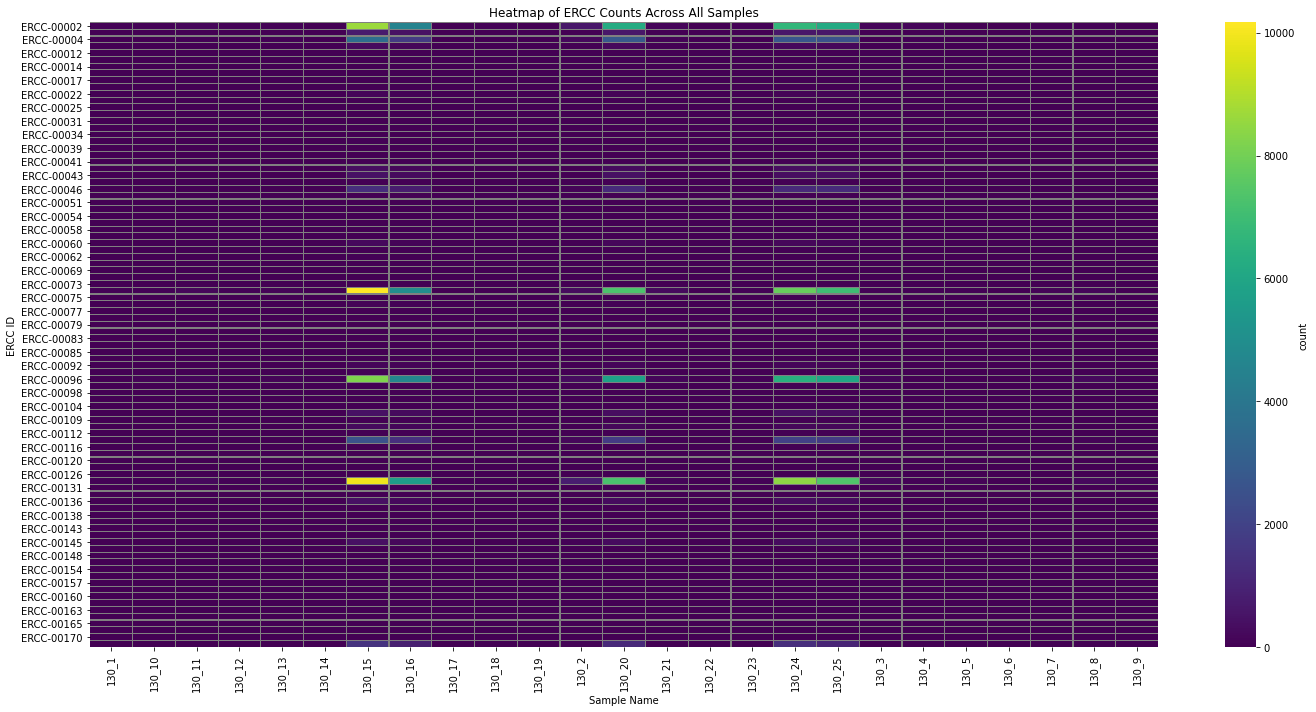

In [40]:
for station in [51, 130]:
    plot_df = counts_ERCC[counts_ERCC['station'] == station]
    plot_ercc_heatmap(plot_df)